##Educação em geofísica
Material didático - algoritmos para aulas de geofísica
#Realce de anomalias - Gradiente horizontal

Citação deste material: Szameitat, L.S.A., Bongiolo, A.B.S. (in prep.). Educação em geofísica: recursos computacionais para tratamento de dados magnetométricos e gravimétricos em sala de aula. Boletim Paranaense de Geociências.

####Referencias
#####• Blakely, R. (1996). Potential Theory in Gravity and Magnetic Applications.Cambridge University, 464p.
#####• Blakely e Simpson (1986). Approximating edges of source bodies from magnetic or gravity anomalies. Geophysics, 51, 1494-8.

Importar bibliotecas

In [2]:
import numpy as np
import scipy.fftpack
from math import radians, sin, cos, sqrt
import matplotlib.pyplot as plt
import pandas as pd

#Função de gradiente horizontal

In [10]:
#Função
def GradHoriz(vetor, nx, ny, dx, dy):
  dx2 = 2*dx
  dy2 = 2*dy
  vetor_GH = np.ones(nx*ny)
  for j in range(1, ny+1):
    jm1 = j - 1
    if jm1 < 1: #condição de borda
      jm1 = 1
    jp1 = j + 1
    if jp1 > ny: #condição de borda
      jp1 = ny
    for i in range(1, nx+1):
      im1 = i - 1
      if im1 < 1: #condição de borda
        im1 = 1
      ip1 = i + 1
      if ip1 > nx: #condição de borda
        ip1 = nx
      #index(i,j,nx) = (j-1) * nx + i #função index em Blakely (1996)
      indexip1 = (jp1-1) * nx + (i-1)
      indexim1 = (j-1) * nx + (im1-1)
      indexjp1 = (jp1-1) * nx + (i-1)
      indexjm1 = (j-2) * nx + (i-1)
      #Análise de valores no espaço
      dfdx = (vetor[indexip1]-vetor[indexim1]) / dx2
      dfdy = (vetor[indexjp1]-vetor[indexjm1]) / dy2
      ij = (j-1) * nx + (i-1)
      vetor_GH[ij] = sqrt(dfdx**2+dfdy**2)

  #As linhas a seguir são ativada se for preciso retornar um grid
  #grid_GH = np.reshape(vetor_GH, (ny, nx))
  #return grid_GH

  return vetor_GH

#Arquivo de entrada
Carregar arquivo de dados no ambiente. O arquivo deve conter colunas de coordenadas (x,y) e campo anômalo.

In [4]:
#Opção 1 - Arquivo para exercício

arquivo = 'https://raw.githubusercontent.com/lszam/ensino/main/geof_filtros/davi.csv'

#Opção 2 - Arquivo próprio
#from google.colab import files
#import io

#uploaded=files.upload()
#arquivo = ' ' #inserir o nome do arquivo


Abrir e visualizar o arquivo de entrada:

In [5]:
dados = pd.read_csv(arquivo, delimiter = ",")
dados

,LESTE,NORTE,ANOM
0,652198,7284826,0.0
1,652298,7284826,0.0
2,652398,7284826,0.0
3,652498,7284826,0.0
4,652598,7284826,0.0
...,...,...,...
12683,663898,7295126,-0.0
12684,663998,7295126,-0.0
12685,664098,7295126,-0.0
12686,664198,7295126,-0.0


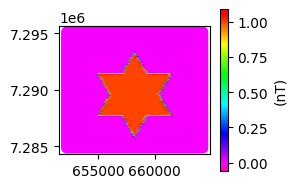

In [6]:
#Plotar mapa
plt.figure(figsize=(3, 3))  #tamanho da figura
entrada_anom = plt.scatter(dados.LESTE, dados.NORTE, c=dados.ANOM, cmap='gist_rainbow_r')
plt.colorbar(entrada_anom, label="(nT)", shrink=0.6) #barra de cores
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

*Organizando os dados de entrada e coletando informações.*

In [7]:
# .to_numpy() converte os valores de dentro da série tipo Pandas em um array NumPy
vetor_LESTE = dados.LESTE.to_numpy()
vetor_NORTE = dados.NORTE.to_numpy()
vetor_ANOM = dados.ANOM.to_numpy()

#Lista de elementos a leste e a norte, sem repetição
pontos_LESTE=[]
pontos_NORTE=[]
[pontos_LESTE.append(item) for item in vetor_LESTE if not pontos_LESTE.count(item)]
[pontos_NORTE.append(item) for item in vetor_NORTE if not pontos_NORTE.count(item)]

#Número de itens a leste e a norte
nx = np.size(pontos_LESTE)
ny = np.size(pontos_NORTE)

#Distancia entre pontos em x e y
dx, dy = np.abs(pontos_LESTE[0]-pontos_LESTE[1]), np.abs(pontos_NORTE[0]-pontos_NORTE[1])


#Gradiente horizontal
A função de gradiente neste programa é feita para receber a entrada como vetor, e a saída também

In [11]:
# Filtro
vetor_GH = GradHoriz(vetor_ANOM, nx, ny, dx, dy)
#Adiciona o resultado no dataframe
dados = dados.assign(GH = vetor_GH)
dados

,LESTE,NORTE,ANOM,GH
0,652198,7284826,0.0,0.0
1,652298,7284826,0.0,0.0
2,652398,7284826,0.0,0.0
3,652498,7284826,0.0,0.0
4,652598,7284826,0.0,0.0
...,...,...,...,...
12683,663898,7295126,-0.0,0.0
12684,663998,7295126,-0.0,0.0
12685,664098,7295126,-0.0,0.0
12686,664198,7295126,-0.0,0.0


Há diversas formas de plotar dados. Neste caso, vamos usar uma matriz 2D e o método imshow(), aplicado para exibir imagens:

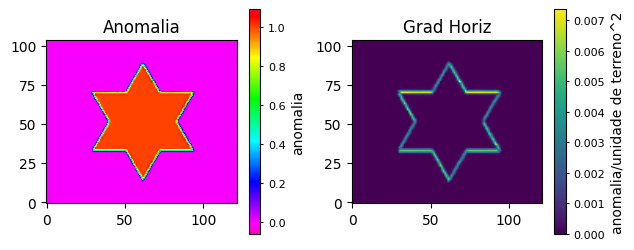

In [13]:
#Retorna grid de 2 dimensões para interpolação (mapas)
grid_GH = np.reshape(vetor_GH, (ny, nx))
grid_ANOM = np.reshape(vetor_ANOM, (ny, nx))

#Plotar mapas
plt.subplot(1, 2, 1)
plt.title("Anomalia")
mapa_ca = plt.imshow(grid_ANOM, cmap='gist_rainbow_r', interpolation='bilinear')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
colorbar_ca = plt.colorbar(mapa_ca, label="anomalia", shrink=0.5)
colorbar_ca.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_ca.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.title("Grad Horiz")
mapa_gh = plt.imshow(grid_GH, cmap='viridis', interpolation='bilinear')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
colorbar_gh = plt.colorbar(mapa_gh, label="anomalia/unidade de terreno^2", shrink=0.5)
colorbar_gh.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_gh.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"
plt.tight_layout()

#Salvar figura
plt.savefig('gradhoriz_py.png', dpi=300, bbox_inches='tight')

plt.show()


Salvar a saída como arquivo csv

In [14]:
dados.to_csv("gradhoriz_py.csv")